In [7]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD
#using hfnet instead of netVlAD and MobileVnet --that is not working 
# this will also help reduce the complexity 
#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model -- this is done easy and simple
import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import json
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# from notebooks.utils import plot_images, plot_matches, add_frame
from hfnet.models import get_model  

In [8]:
# send the path to the image directory and get the path to all the images in it
def image_directory_parser(path, viewer=True, number= 4):    
    globs=['*.jpg', '*.png', '*.jpeg', '*.JPG', '*.PNG']
    ## can also use sufix instead of with method
    image_path = []
    for g in globs:
        image_path += list(path.glob("**/"+g))
    print(len(image_path))
    if viewer:
        nrows = number
        ncols = number
        fig = plt.gcf()
        fig.set_size_inches(ncols*4, ncols*4)
        for i in range(2*number):
            sp = plt.subplot(nrows, ncols, i + 1)
            sp.axis('Off') # Don't show axes (or gridlines)
            img = mpimg.imread((image_path[i]))
            plt.imshow(img)
        plt.show()
    return image_path

In [9]:
def Trajectory5(path_to_json, skip=0):
	useful_filenames = path_to_json/"useful_filenames.json"
	useful_tvecs = path_to_json/"useful_tvecs.json"
	useful_rvecs = path_to_json/"useful_rvecs.json"
	with open(useful_rvecs) as f:
		rvecs = json.load(f)
	with open(useful_tvecs) as f:
		tvecs = json.load(f)
	with open(useful_filenames) as f:
		usefull_filenames = json.load(f)
	current_skip = 0
	from_useful = {}
	for i in tqdm(range(len(usefull_filenames))):
		if current_skip<skip:
			current_skip+=1
			continue
		current_skip = 0
		from_useful[usefull_filenames[i]]= {"tvecs": tvecs[i], "rvecs": rvecs[i]}
	return from_useful

In [10]:
path_to_images_for_map = Path('/home/Hierarchical-Localization/datasets/Trajectory5/skip9')

2003


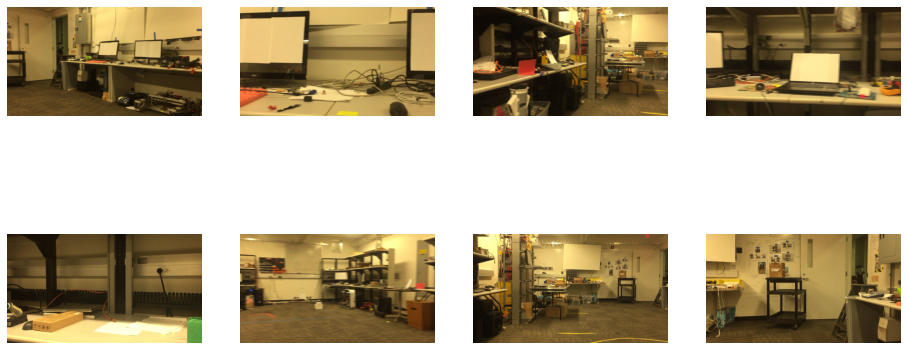

In [11]:
image_path = image_directory_parser(path_to_images_for_map, viewer=True, number = 4) 
## wow this is intresting as the json files have only 20031 images

In [12]:
path_to_json = Path('/home/Hierarchical-Localization/datasets/Trajectory5/UsefulPosesT5GS2')

In [13]:
using = Trajectory5(path_to_json, skip=9) ## this dict will always be the same 

100%|██████████| 20031/20031 [00:00<00:00, 1074017.63it/s]


In [14]:
## This funciton is diffrent in trajectory 5 because of the skip parameter
# image dictionary creator gives image, its name and index as dictionary
# def dictionary_of_images(image_path, using, path_to_images_for_map):
#     list_of_image = list(using.keys())
#     image_dict ={}
#     to_save = (path_to_images_for_map.parent)/"skip9"
#     index = 0
#     for i,j in tqdm(enumerate(image_path)):
#         if str(j.name) in list_of_image:
#             image_array = cv2.imread(str(j))
#     #         print(image_path[i].name)
#             image_to_save = to_save/j.name
#             copyfile(j,image_to_save)
#             image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
#             image_dict[index] = {"image":image_array, "name": image_path[i].name, "number": index}
#             index+=1
#     return image_dict
# image dictionary creator gives image, its name and index as dictionary
def dictionary_of_images(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
#         print(image_path[i].name)
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[i] = {"image":image_array, "name": image_path[i].name, "number": i}
    return image_dict


In [15]:
image_dict = dictionary_of_images(image_path)
print(len(image_dict))

2003it [00:19, 104.20it/s]

2003


In [26]:
# print(image_dict[0])

In [27]:
# this finds the global matrix and 
def global_dict_matrix_and_H5_map(config, image_dict):
    predictions_dict = {}
    global_feature_path = (config["output"])/"global_features.h5"
    global_feature_file = h5py.File(str(global_feature_path), 'w')
    checkpoint_path = Path(config["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        for i in tqdm(range(len(image_dict))):
            data = image_dict[i] ## selecting using index
            predictions = net.predict(data, keys=keys)
            predictions_dict[i] = {"global_descriptor":predictions['global_descriptor'], "name" : data['name']}   
            if i == 0:
                global_matrix = np.array(predictions['global_descriptor'])
            else:
                global_matrix = np.vstack((global_matrix,predictions['global_descriptor']))
            grp = global_feature_file.create_group(data['name'])
            grp.create_dataset('global_descriptor', data=predictions['global_descriptor'])
        global_feature_file.close()
    return predictions_dict, global_matrix
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)
## needs both global matrix and dict as we need to give names too
## I am idiot if I keep wiritng codes like this one lol ;)
# Need to change it hehehe
# Writing the .txt file.
def text_file_for_global_matches(global_feature_dict, global_feature_matrix, path, number): 
    predictions_dict_matches = {}
    for i in tqdm(range(len(global_feature_dict))):
        current_descriptor = global_feature_matrix[i, :]
        neighbours = compute_distance(current_descriptor, global_feature_matrix)
        predictions_dict_matches[i] = ((np.argsort(neighbours))[:number])[1 :]
    #first writing the file
    output_file_txt = path/"global_feature.txt"
    with open(output_file_txt, 'w') as f:
        for i in tqdm(range(len(predictions_dict_matches))):
            current_image_name = global_feature_dict[i]["name"]
            current_image_matches = predictions_dict_matches[i]
            string_list = []
            for j in range(len(current_image_matches)):
                    if i == 0 and j ==0:
                        making_a_string = current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    
                    else: 
                        making_a_string = "\n" + current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    f.write(making_a_string)  
    ## checking common lines and rewriting
    image_list_for_finding_common_separated = []
    with open(output_file_txt, 'r') as f:
        image_list_for_finding_common = [l.strip() for l in f]
    for i in range(len(image_list_for_finding_common)):
        current_index_value = image_list_for_finding_common[i]
        current_index_value = list(current_index_value.split(" "))
        image_list_for_finding_common_separated.append(sorted(current_index_value))
    ilf = sorted(image_list_for_finding_common_separated)
    final_list = []
    for i in range(len(ilf)):
        if ilf[i] in final_list:
            pass
        else:
            final_list.append(ilf[i])
    with open(output_file_txt, 'w') as f:
        for i in range(len(final_list)):
            if i == 0:
                making_a_string = final_list[i][0]+ " " + final_list[i][1]
            else:
                making_a_string = "\n" + final_list[i][0]+ " " + final_list[i][1]
            f.write(making_a_string)

In [3]:
output_path = Path("/home/Hierarchical-Localization/outputs/sfm_T5_skip_9_pba")
if output_path.exists() == False:
    output_path.mkdir()
checkpoint_path = Path("/home/Hierarchical-Localization/weights/vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white")

In [31]:
config_global = {'output':output_path, 'checkpoint_path':checkpoint_path, 'data': {'name': 'aachen', 'load_db': False, 'load_queries': True, 'resize_max': 960}, 'model': {'name': 'netvlad_original', 'local_descriptor_layer': 'conv3_3', 'image_channels': 1}, 'weights': 'vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white'}         
global_dict_map, global_matrix = global_dict_matrix_and_H5_map(config_global, image_dict)

I0216 19:40:52.213833 139860587419456 base_model.py:411] Restoring variables: 
	vgg16_netvlad_pca/WPCA/bias
	vgg16_netvlad_pca/WPCA/kernel
	vgg16_netvlad_pca/assignment/kernel
	vgg16_netvlad_pca/average_rgb
	vgg16_netvlad_pca/cluster_centers
	vgg16_netvlad_pca/conv1_1/bias
	vgg16_netvlad_pca/conv1_1/kernel
	vgg16_netvlad_pca/conv1_2/bias
	vgg16_netvlad_pca/conv1_2/kernel
	vgg16_netvlad_pca/conv2_1/bias
	vgg16_netvlad_pca/conv2_1/kernel
	vgg16_netvlad_pca/conv2_2/bias
	vgg16_netvlad_pca/conv2_2/kernel
	vgg16_netvlad_pca/conv3_1/bias
	vgg16_netvlad_pca/conv3_1/kernel
	vgg16_netvlad_pca/conv3_2/bias
	vgg16_netvlad_pca/conv3_2/kernel
	vgg16_netvlad_pca/conv3_3/bias
	vgg16_netvlad_pca/conv3_3/kernel
	vgg16_netvlad_pca/conv4_1/bias
	vgg16_netvlad_pca/conv4_1/kernel
	vgg16_netvlad_pca/conv4_2/bias
	vgg16_netvlad_pca/conv4_2/kernel
	vgg16_netvlad_pca/conv4_3/bias
	vgg16_netvlad_pca/conv4_3/kernel
	vgg16_netvlad_pca/conv5_1/bias
	vgg16_netvlad_pca/conv5_1/kernel
	vgg16_netvlad_pca/conv5_2/bias


In [32]:
text_file_for_global_matches(global_dict_map, global_matrix,output_path,10)

100%|██████████| 2003/2003 [00:00<00:00, 51544.21it/s]


In [7]:
### Bringing in HLOC
%load_ext autoreload
%autoreload 2
from hloc import extract_features, match_features, reconstruction, visualization
path_to_images_for_map = Path('/home/Hierarchical-Localization/datasets/Trajectory5/skip9')

In [8]:
feature_conf_superpoint = {'output': 'features_superpoint', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}

In [9]:
extract_features.main(feature_conf_superpoint,path_to_images_for_map,output_path)
# here finding the features for all the image because of the directory setting.

[02/16/2021 19:46:37 INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'features_superpoint',
 'preprocessing': {'grayscale': True, 'resize_max': 960}}


Loaded SuperPoint model


[02/16/2021 19:46:41 INFO] Found 2003 images in root /home/Hierarchical-Localization/datasets/Trajectory5/skip9.
100%|██████████| 2003/2003 [00:23<00:00, 83.73it/s] 
[02/16/2021 19:47:05 INFO] Finished exporting features.


In [10]:
matcher_conf = {'output': 'matches-superglue', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features = feature_conf_superpoint['output']
sfm_pairs = output_path/"global_feature.txt"
match_features.main(matcher_conf, sfm_pairs, features, output_path)

[02/16/2021 19:47:11 INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
  0%|          | 2/11211 [00:00<09:57, 18.76it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 11211/11211 [10:31<00:00, 17.76it/s]
[02/16/2021 19:57:42 INFO] Finished exporting matches.


In [11]:
sfm_dir = output_path/'sfm_superpoint+superglue'
feature_file = output_path/'features_superpoint.h5'
match_file = output_path/'features_superpoint_matches-superglue_global_feature.h5'
## check why the name given above is coming and change it 

In [12]:
import argparse
import logging
from pathlib import Path
import shutil
import multiprocessing
import subprocess
import pprint

from hloc.utils.read_write_model import read_cameras_binary
from hloc.utils.database import COLMAPDatabase
from hloc.triangulation import (
    import_features, import_matches, geometric_verification)


def create_empty_db(database_path):
    logging.info('Creating an empty database...')
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    db.commit()
    db.close()


def import_images(colmap_path, sfm_dir, image_dir, database_path,
                  single_camera=False):
    logging.info('Importing images into the database...')
    images = list(image_dir.iterdir())
    if len(images) == 0:
        raise IOError(f'No images found in {image_dir}.')

    # We need to create dummy features for COLMAP to import images with EXIF
    dummy_dir = sfm_dir / 'dummy_features'
    dummy_dir.mkdir()
    for i in images:
        with open(str(dummy_dir / (i.name + '.txt')), 'w') as f:
            f.write('0 128')

    cmd = [
        str(colmap_path), 'feature_importer',
        '--database_path', str(database_path),
        '--image_path', str(image_dir),
        '--import_path', str(dummy_dir),
        '--ImageReader.single_camera',
        str(int(single_camera))]
    ret = subprocess.call(cmd)
    if ret != 0:
        logging.warning('Problem with feature_importer, exiting.')
        exit(ret)

    db = COLMAPDatabase.connect(database_path)
    db.execute("DELETE FROM keypoints;")
    db.execute("DELETE FROM descriptors;")
    db.commit()
    db.close()
    shutil.rmtree(str(dummy_dir))


def get_image_ids(database_path):
    db = COLMAPDatabase.connect(database_path)
    images = {}
    for name, image_id in db.execute("SELECT name, image_id FROM images;"):
        images[name] = image_id
    db.close()
    return images


# def run_reconstruction(colmap_path, model_path, database_path, image_dir,
#                        min_num_matches=None):
#     logging.info('Running the 3D reconstruction...')
#     model_path.mkdir(exist_ok=True)

#     cmd = [
#         str(colmap_path), 'mapper',
#         '--database_path', str(database_path),
#         '--image_path', str(image_dir),
#         '--output_path', str(model_path)]
# #     ,
# #         '--Mapper.num_threads', str(min(multiprocessing.cpu_count(), 16))]
#     if min_num_matches:
#         cmd += ['--Mapper.min_num_matches', str(min_num_matches)]
#     logging.info(' '.join(cmd))
#     ret = subprocess.call(cmd)
#     if ret != 0:
#         logging.warning('Problem with mapper, exiting.')
#         exit(ret)

#     models = list(model_path.iterdir())
#     if len(models) == 0:
#         logging.error('Could not reconstruct any model!')
#         return False
#     logging.info(f'Reconstructed {len(models)} models.')

#     largest_model = None
#     largest_model_num_images = 0
#     for model in models:
#         num_images = len(read_cameras_binary(str(model / 'cameras.bin')))
#         if num_images > largest_model_num_images:
#             largest_model = model
#             largest_model_num_images = num_images
#     assert largest_model_num_images > 0
#     logging.info(f'Largest model is #{largest_model.name} '
#                  'with {largest_model_num_images} images.')

#     stats_raw = subprocess.check_output(
#         [str(colmap_path), 'model_analyzer',
#          '--path', str(largest_model)])
#     stats_raw = stats_raw.decode().split("\n")
#     stats = dict()
#     for stat in stats_raw:
#         if stat.startswith("Registered images"):
#             stats['num_reg_images'] = int(stat.split()[-1])
#         elif stat.startswith("Points"):
#             stats['num_sparse_points'] = int(stat.split()[-1])
#         elif stat.startswith("Observations"):
#             stats['num_observations'] = int(stat.split()[-1])
#         elif stat.startswith("Mean track length"):
#             stats['mean_track_length'] = float(stat.split()[-1])
#         elif stat.startswith("Mean observations per image"):
#             stats['num_observations_per_image'] = float(stat.split()[-1])
#         elif stat.startswith("Mean reprojection error"):
#             stats['mean_reproj_error'] = float(stat.split()[-1][:-2])

#     return stats


def main(sfm_dir, image_dir, pairs, features, matches,
         colmap_path='colmap', single_camera=False,
         skip_geometric_verification=False,
         min_match_score=None, min_num_matches=None):

    assert features.exists(), features
    assert pairs.exists(), pairs
    assert matches.exists(), matches

    sfm_dir.mkdir(parents=True, exist_ok=True)
    database = sfm_dir / 'database.db'
    models = sfm_dir / 'models'
    models.mkdir(exist_ok=True)

    create_empty_db(database)
    import_images(
        colmap_path, sfm_dir, image_dir, database, single_camera)
    image_ids = get_image_ids(database)
    import_features(image_ids, database, features)
    import_matches(image_ids, database, pairs, matches,
                   min_match_score, skip_geometric_verification)
    if not skip_geometric_verification:
        geometric_verification(colmap_path, database, pairs)
#     stats = run_reconstruction(
#         colmap_path, models, database, image_dir, min_num_matches)
#     stats['num_input_images'] = len(image_ids)
#     logging.info(f'Statistics:\n{pprint.pformat(stats)}')

In [13]:
main(
    sfm_dir,
    path_to_images_for_map,
    sfm_pairs,
    feature_file,
    match_file)

[02/16/2021 19:57:42 INFO] Creating an empty database...
[02/16/2021 19:57:42 INFO] Importing images into the database...
[02/16/2021 19:58:02 INFO] Importing features into the database...
100%|██████████| 2003/2003 [00:00<00:00, 2608.55it/s]
[02/16/2021 19:58:03 INFO] Importing matches into the database...
100%|██████████| 11211/11211 [00:05<00:00, 2077.92it/s]
[02/16/2021 19:58:09 INFO] Performing geometric verification of the matches...


In [4]:
### geo registration model directory
sfm_dir = output_path/'sfm_superpoint+superglue'
geo_registration_dir = sfm_dir/"geo_registered_model"
if geo_registration_dir.exists() == False:
    geo_registration_dir.mkdir()

In [5]:

import subprocess
cmd = ["colmap", "model_aligner",
       '--input_path', str(sfm_dir/"models"/"0"),
       '--output_path', str(geo_registration_dir),
       '--ref_images_path', str(output_path/'output_world_file.txt'),
       '--robust_alignment_max_error', str(20)]


In [6]:
subprocess.call(cmd)

0

In [16]:
## find the error within itself
import os
import sys
import collections
import numpy as np
import struct
import argparse
BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])
class Image(BaseImage):
    def qvec2rotmat(self):
        return qvec2rotmat(self.qvec)
def read_images_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        for image_index in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi")
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            image_name = ""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":   # look for the ASCII 0 entry
                image_name += current_char.decode("utf-8")
                current_char = read_next_bytes(fid, 1, "c")[0]
            num_points2D = read_next_bytes(fid, num_bytes=8,
                                           format_char_sequence="Q")[0]
            x_y_id_s = read_next_bytes(fid, num_bytes=24*num_points2D,
                                       format_char_sequence="ddq"*num_points2D)
            xys = np.column_stack([tuple(map(float, x_y_id_s[0::3])),
                                   tuple(map(float, x_y_id_s[1::3]))])
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))
            images[image_name] = Image(
                id=image_id, qvec=qvec, tvec=tvec,
                camera_id=camera_id, name=image_name,
                xys=xys, point3D_ids=point3D_ids)
    return images
def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)

In [17]:
def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])
def colmap_to_global(_tvec, _qvec):
    return -np.matmul(qvec2rotmat(_qvec).transpose(), _tvec)

In [18]:
def global_and_colmap(name, read_images_binary, using):
    tvec = using[name]['tvecs']
    rvec = using[name]['rvecs']
    tvec_colmap = read_images_binary[name][2]
    rvec_colmap = read_images_binary[name][1]
    CtG= colmap_to_global(tvec_colmap, rvec_colmap)
    return tvec, CtG

In [19]:
def error(tvec, CtG):
    return np.linalg.norm(tvec-CtG)
    

In [21]:
image_bin_path = geo_registration_dir/"images.bin"
ReadImagesBinary = read_images_binary(image_bin_path) ###not required now

In [22]:
def within_itself(using, ReadImagesBinary, path):
    list_of_registered = list(ReadImagesBinary.keys())
    file_name = 'with_itself_map_and_GT.txt'
    error_list = []
    with open(path/file_name, 'w') as f:        
        for i  in range(len(list_of_registered)):
            tvec, CtG = global_and_colmap(list_of_registered[i], ReadImagesBinary, using)
            err = error(tvec, CtG)
            error_list.append(err)
            if i == 0:
                string = list_of_registered[i]+ " " + str(tvec) + " " +str(CtG) + " " + str(err)
            else:
                string ='\n'+ list_of_registered[i]+ " " + str(tvec) + " " +str(CtG) + " " + str(err)
            f.write(string)
        error_list = np.asarray(error_list,  dtype=np.float32)
        string = '\n'+"The median error is "+ str(np.median(error_list))
        f.write(string)
        string = '\n'+"The mean error is "+ str(np.mean(error_list))
        f.write(string)
        string = '\n'+"The max error is "+ str(np.max(error_list))
        f.write(string)     

In [ ]:
within_itself(using, ReadImagesBinary, output_path)

In [31]:
import jsonparser

In [32]:
names_trans_rot = jsonparser.parser("/home/Hierarchical-Localization/datasets/Trajectory3/UsefulPoses")

In [33]:
def file_creator_error(original_dict_json, file_name_read, file_name_write, path):
    list_of_registered = list(original_dict_json.keys())
    with open(path/file_name_read, 'r') as f:
        Lines = f.readlines()
    error_list = []
    with open(path/file_name_write, 'w') as f:
        for line in Lines:
            line = line.split()
            name = line[0]
            qvec = np.asarray(line[1:5], dtype=np.float32)
#             qvec = np.array([line[2], line[3], line[4], line[1]],dtype=np.float32)
            tvec = np.asarray(line[5:8], dtype=np.float32)
            tvec_world = colmap_to_global(tvec, qvec)
            tvec_ori = original_dict_json[name]["tvec"]
            er =  error(tvec_world, tvec_ori)
            error_list.append(er)
            string = name + " "+ str(tvec_ori)+ " "+str(tvec_world)+ " " + str(er)+ "\n"
            f.write(string)
        error_list = np.asarray(error_list,  dtype=np.float32)
        string = "The median error is "+ str(np.median(error_list))+ '\n'
        f.write(string)
        string = "The mean error is "+ str(np.mean(error_list))+ '\n'
        f.write(string)
        string = "The max error is "+ str(np.max(error_list))
        f.write(string)

In [34]:
output_queries_intrinsic_txt = Path("/home/Hierarchical-Localization/outputs/sfm_T5_skip_9")

In [77]:
output_h5_files = Path('/home/Hierarchical-Localization/outputs/sfm_T5_skip_9/Image_added_scale_0.95_masked_matches_50')
feat_name = 'features_superpoint_T3_Image_added_scale_0.95_masked.h5'
mat_name = 'features_superpoint_matches-superglue_T3_Image_added_scale_0.95_masked_Image_added_scale_0.95_masked.h5'
loc_pairs= output_h5_files/"Image_added_scale_0.95_masked.txt"
res_name = 'Image_added_scale_0.95_masked_T3results.txt'
res_name_err= "Image_added_scale_0.95_masked_T3results_errors.txt"

In [78]:
from hloc import localize_sfm
localize_sfm.main(geo_registration_dir,
                 output_queries_intrinsic_txt/"queries_UsefulImages_with_intrinsics.txt",
                 loc_pairs,
                 output_h5_files/feat_name,
                 output_h5_files/mat_name,
                 output_path/res_name,
                 covisibility_clustering=False)

[02/18/2021 19:41:07 INFO] Importing 1637 queries in queries_UsefulImages_with_intrinsics.txt
[02/18/2021 19:41:07 INFO] Reading 3D model...
[02/18/2021 19:41:10 INFO] Starting localization...
100%|██████████| 1637/1637 [04:44<00:00,  5.75it/s]
[02/18/2021 19:45:55 INFO] Localized 1637 / 1637 images.
[02/18/2021 19:45:55 INFO] Writing poses to /home/Hierarchical-Localization/outputs/sfm_T5_skip_9_pba/Image_added_scale_0.95_masked_T3results.txt...
[02/18/2021 19:45:55 INFO] Writing logs to /home/Hierarchical-Localization/outputs/sfm_T5_skip_9_pba/Image_added_scale_0.95_masked_T3results.txt_logs.pkl...
[02/18/2021 19:46:11 INFO] Done!


In [39]:
file_creator_error(names_trans_rot,res_name, res_name_err, output_path)

In [74]:
output_h5_files = Path('/home/Hierarchical-Localization/outputs/sfm_T5_skip_9/Image_added_0.35_grey')
feat_name = 'features_superpoint_T3_Image_added_scale_0.35_grey.h5'
mat_name = 'features_superpoint_matches-superglue_T3_Image_added_scale_0.35_grey_Image_added_scale_0.35_grey.h5'
loc_pairs= output_h5_files/"Image_added_scale_0.35_grey.txt"
res_name = 'Image_added_scale_0.35_grey_T3results.txt'
res_name_err= 'Image_added_scale_0.35_grey_T3results_err.txt'


In [75]:
from hloc import localize_sfm
localize_sfm.main(geo_registration_dir,
                 output_queries_intrinsic_txt/"queries_UsefulImages_with_intrinsics.txt",
                 loc_pairs,
                 output_h5_files/feat_name,
                 output_h5_files/mat_name,
                 output_path/res_name,
                 covisibility_clustering=False)

[02/18/2021 11:41:44 INFO] Importing 1637 queries in queries_UsefulImages_with_intrinsics.txt
[02/18/2021 11:41:44 INFO] Reading 3D model...
[02/18/2021 11:41:47 INFO] Starting localization...
100%|██████████| 1637/1637 [02:23<00:00, 11.43it/s]
[02/18/2021 11:44:10 INFO] Localized 1637 / 1637 images.
[02/18/2021 11:44:10 INFO] Writing poses to /home/Hierarchical-Localization/outputs/sfm_T5_skip_9_pba/Image_added_scale_0.35_grey_T3results.txt...
[02/18/2021 11:44:10 INFO] Writing logs to /home/Hierarchical-Localization/outputs/sfm_T5_skip_9_pba/Image_added_scale_0.35_grey_T3results.txt_logs.pkl...
[02/18/2021 11:44:19 INFO] Done!


In [76]:
file_creator_error(names_trans_rot,res_name, res_name_err, output_path)